# Travail personnel MIG

# Mise en place de base

In [1]:
!curl -sSL -q -o - "https://cloud.minesparis.psl.eu/index.php/s/MGp21fRa8LEzO3f/download?path=%2F&files=mig25_data.tgz" | tar -xzv

data/
data/TA_1d.csv
data/TP_1d.csv
data/CF_1d.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [5]:
cf = pd.read_csv("data/CF_1d.csv",index_col = 'Date', parse_dates = True)
ta = pd.read_csv("data/TA_1d.csv",index_col ='Date', parse_dates = True)
tp = pd.read_csv("data/TP_1d.csv",index_col ='Date', parse_dates = True)

cf_FR = cf.loc[:,'FR'].to_frame()
ta_FR = ta.loc[:,'FR10':'FRL0']
tp_FR = tp.loc[:,'FR10':'FRL0']

data = cf_FR
data['TA'] = ta_FR.mean(axis = 1)
data['TP'] = tp_FR.mean(axis = 1)

data.columns = ['CF','TA','TP']
data

,CF,TA,TP
Date,,,
2015-01-01,0.385681,273.075131,3.639429e-07
2015-01-02,0.398427,276.436800,5.394107e-05
2015-01-03,0.394678,279.928447,2.041981e-04
2015-01-04,0.431319,279.277552,5.923627e-05
2015-01-05,0.543654,275.279690,1.637417e-06
...,...,...,...
2023-12-27,0.504015,280.180736,3.078666e-05
2023-12-28,0.477661,281.762482,5.972527e-05
2023-12-29,0.463799,282.037572,5.098073e-05


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Features & Target
X = data.drop(columns="CF")
y = data["CF"]

# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False) 
# par défaut shuffle est à True, mais alors ça mélange les données 
# (donc on perd l'ordre chrono, avant de choisir l'échantillon). Pour nous ça serait un pb.

# Normalisation
scaler = StandardScaler().set_output(transform="pandas") # StandardScaler est une classe Python.
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

results = {"Actual": y_test}

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

def display_result(y_true, y_pred):
    dmap = {
        12: 'DJF', 1: 'DJF', 2: 'DJF',
        3: 'MAM', 4: 'MAM', 5: 'MAM',
        6: 'JJA', 7: 'JJA', 8: 'JJA',
        9: 'SON', 10: 'SON', 11: 'SON'
    }
    cmap = {"DJF": "tab:blue", "MAM": "tab:green",
            "JJA": "tab:red", "SON": "tab:orange"}
    seasons = y_true.index.month.map(dmap)
    colors = seasons.map(cmap)

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")
    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2 : 
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, c=colors, s=10)

    # Diagonale
    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_xlim(lb, ub)
    ax2.set_ylim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    # Légende
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=s, 
                   markerfacecolor=cmap[s], markersize=6)
        for s in ["DJF", "MAM", "JJA", "SON"]
    ]
    ax2.legend(handles=handles, title="Season")

    plt.show()

# Random Forest Regressor

D'abord sans GridSearch :

R2: -0.355770
MSE: 0.014627



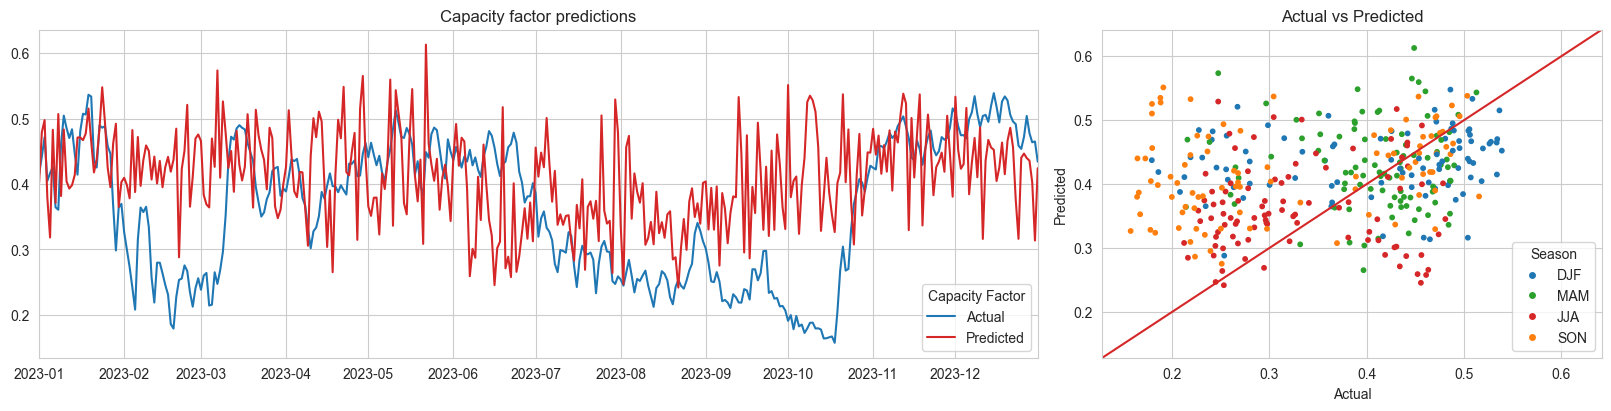

In [8]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)  # apprentissage supervisé

y_pred = rfr.predict(X_test)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["Random Forest"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Paramètres

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

display_result(y_test, y_pred)

Avec GridSearch :

R2: 0.044427
MSE: 0.010309



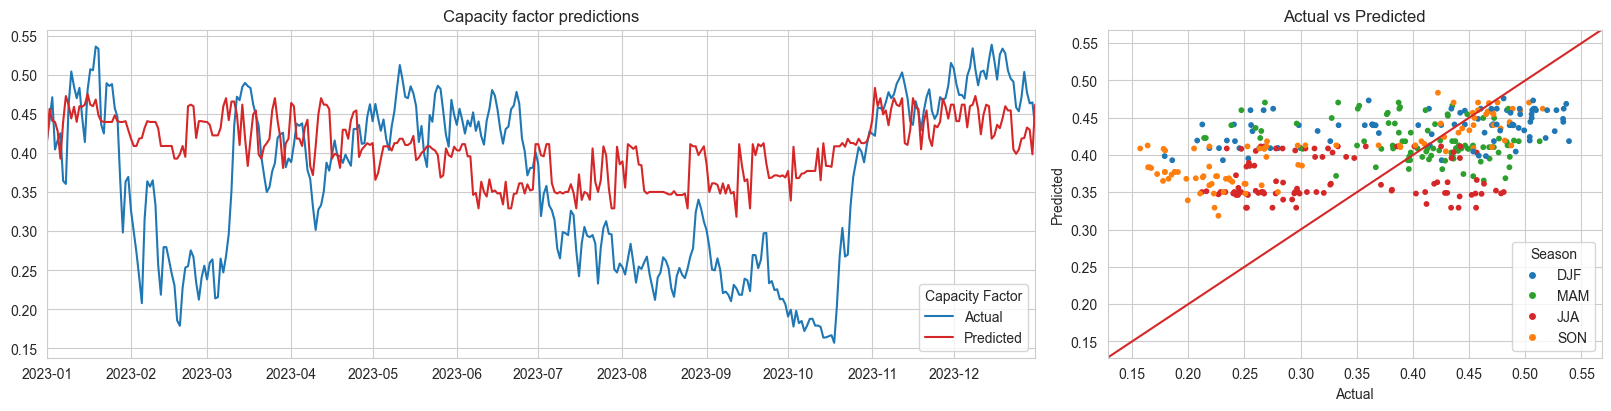

In [9]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': np.arange(1,20),
              'max_depth': np.arange(1,20)
}

reg = RandomForestRegressor(random_state=0)  # modèle d'arbre de décision
cv = GridSearchCV(reg, param_grid=params, n_jobs = 2)  # recherche par grille. CV pour cross validation.
cv.fit(X_train, y_train)  # apprentissage supervisé

y_pred = cv.predict(X_test)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["RFRCV"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

display_result(y_test, y_pred)

Avec K-Fold Validation : 

R2: 0.045283
MSE: 0.010300



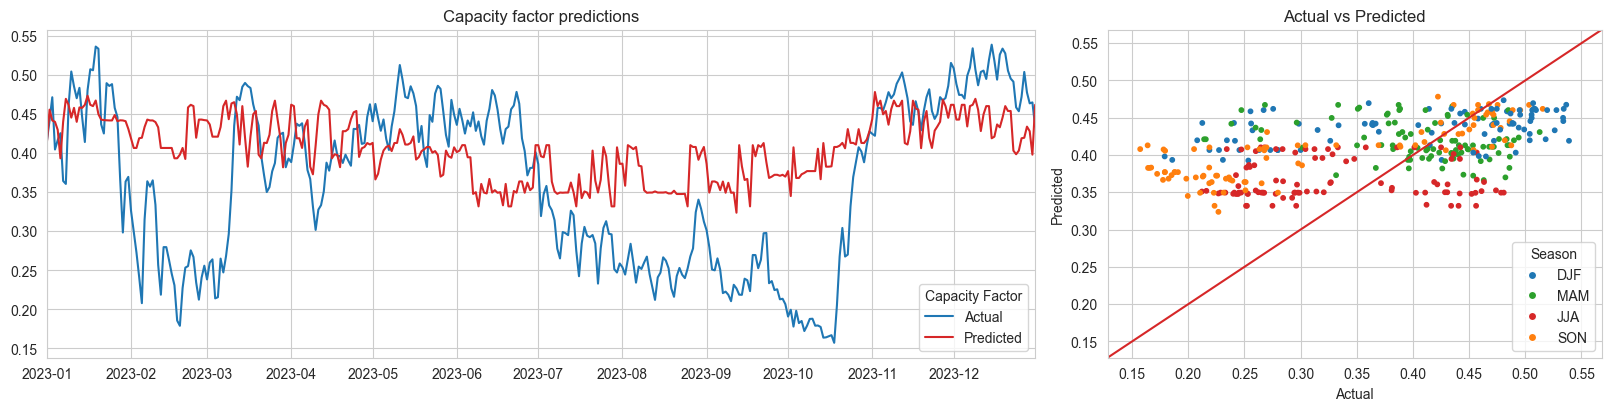

In [10]:
from sklearn.model_selection import GroupKFold

params = {'n_estimators': np.arange(1,20),
              'max_depth': np.arange(1,20)
}


gkf=GroupKFold(n_splits=8, shuffle = False)

n_samples = X_train.shape[0]            # 2920
n_groups = 8
group_size = n_samples // n_groups      # 365

groups = np.repeat(np.arange(n_groups), group_size)

reg = RandomForestRegressor(random_state=0)  # modèle d'arbre de décision
cv = GridSearchCV(reg, param_grid=params, n_jobs = 2, cv = gkf)  # recherche par grille. CV pour cross validation.
cv.fit(X_train, y_train, groups = groups)  # apprentissage supervisé

y_pred = cv.predict(X_test)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["RFRCVK-folds"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

display_result(y_test, y_pred)

Refaire la même chose mais avec le leave one out

In [29]:
from sklearn.model_selection import GroupKFold,  LeaveOneGroupOut

logo = LeaveOneGroupOut()
#for a , b in logo.split(X_train, y_train, groups = X_train.index.year):
  #  print(a,b)

# Descente de Gradient

Stochastique

R2: -22262696797543040322824568832.000000
MSE: 240184789026794368858587136.000000



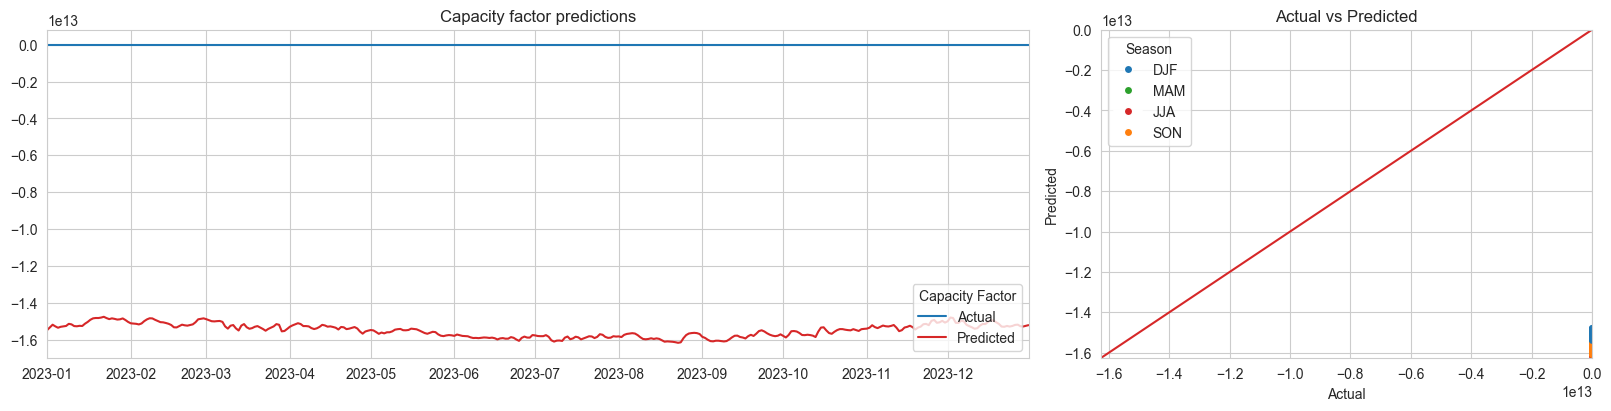

In [11]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(random_state=0)
sgd.fit(X_train, y_train)  # apprentissage supervisé

y_pred = sgd.predict(X_test)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["SGD"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Paramètres

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")

print()

display_result(y_test, y_pred)

Gradient boosting sans GridSearch

R2: -0.021888
MSE: 0.011025



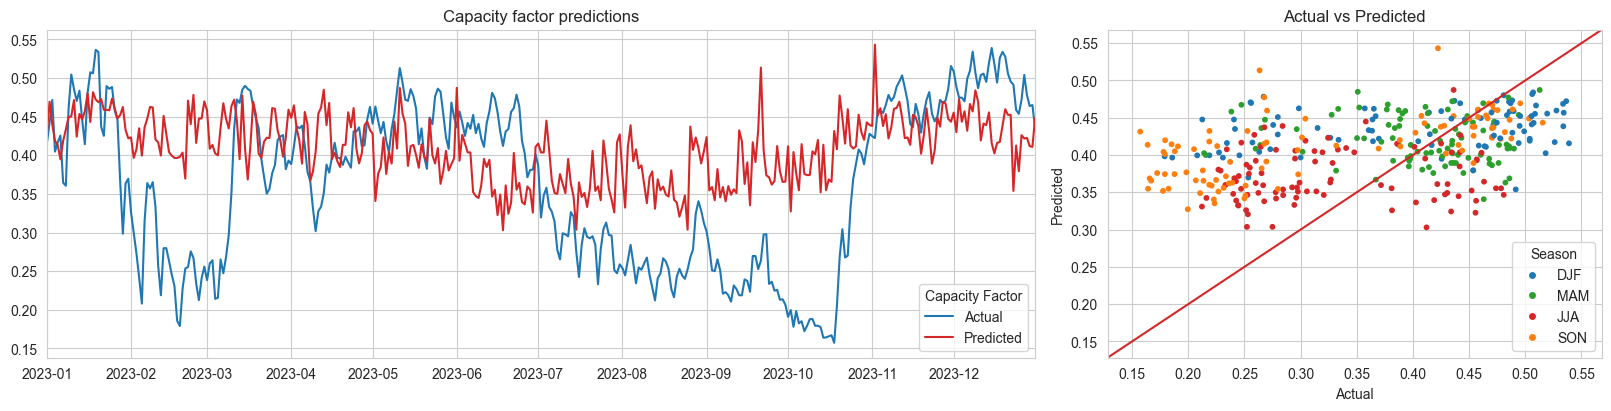

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)  # apprentissage supervisé

y_pred = gbr.predict(X_test)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["GBR"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Paramètres

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")

print()

display_result(y_test, y_pred)

Gradient Boosting avec GridSearch

R2: 0.044427
MSE: 0.010309



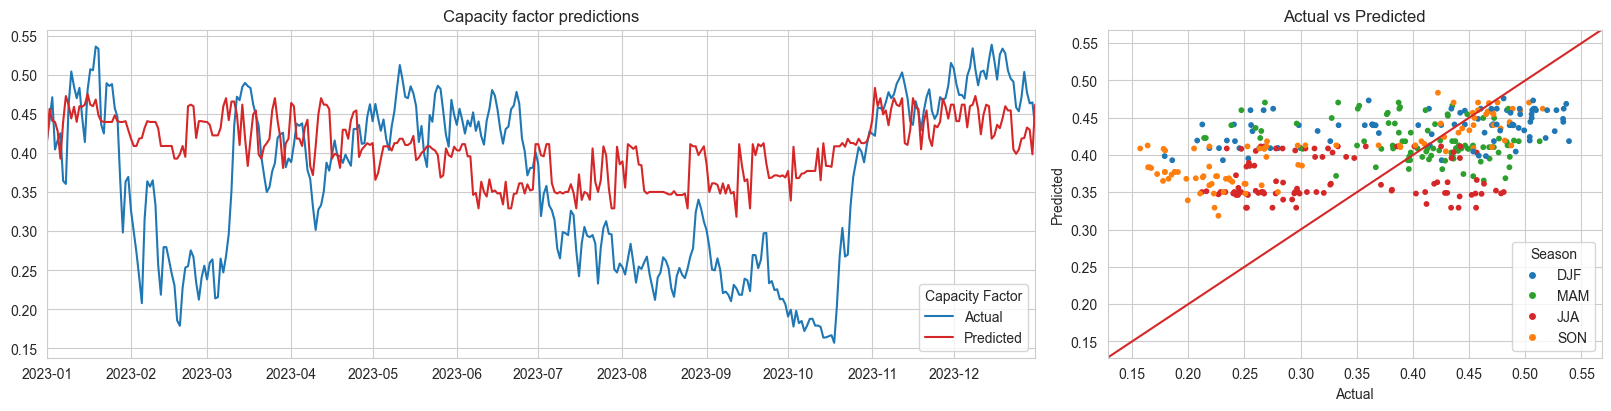

In [13]:
params = {'n_estimators': np.arange(1,20),
              'max_depth': np.arange(1,20)
}

reg = RandomForestRegressor(random_state=0)  # modèle d'arbre de décision
cv = GridSearchCV(reg, param_grid=params, n_jobs = 2)  # recherche par grille. CV pour cross validation.
cv.fit(X_train, y_train)  # apprentissage supervisé

y_pred = cv.predict(X_test)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["GBRCV"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

display_result(y_test, y_pred)

# PCA

In [14]:
X = data.drop(columns="CF")
y = data["CF"]

# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False) 
# par défaut shuffle est à True, mais alors ça mélange les données 
# (donc on perd l'ordre chrono, avant de choisir l'échantillon). Pour nous ça serait un pb.

# Normalisation
scaler = StandardScaler().set_output(transform="pandas") # StandardScaler est une classe Python.
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

results = {"Actual": y_test}

# Application de la PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_train_std)

X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)
X_train_std

,TA,TP
Date,,
2015-01-01,-1.879944,-0.819556
2015-01-02,-1.352464,-0.400503
2015-01-03,-0.804590,0.774728
2015-01-04,-0.906722,-0.359087
2015-01-05,-1.534026,-0.809595
...,...,...
2022-12-27,-0.910759,-0.715634
2022-12-28,-0.533873,-0.203936
2022-12-29,-0.445050,0.504672


In [15]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Features & Target
Xt = pd.concat([taFR,tpFR],axis=1)
yt = cfFR.copy()
# Séparation des données d'entrainement et de test
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=365, shuffle=False)

# Normalisation
scaler = StandardScaler().set_output(transform="pandas")
Xt_train_std = scaler.fit_transform(Xt_train)
Xt_test_std = scaler.transform(Xt_test)

results = {"Actual": yt_test}

# 2. PCA
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(Xt_train_std)
X_test_pca = pca.transform(Xt_test_std)
X_train_pca.shape

X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)
X_train_pca

,0,1,2,3
0,-8.053476,-3.701168,-0.246151,0.082281
1,-5.793614,-1.904511,-0.659267,1.086717
2,-3.863380,2.434055,-1.493542,3.872270
3,-3.903074,-1.788882,0.681769,0.364768
4,-6.480721,-3.505889,-0.262578,0.094684
...,...,...,...,...
2915,-3.787763,-2.878907,-0.176074,0.019202
2916,-2.230881,-0.616930,-2.410050,-0.614999
2917,-2.245963,1.467826,1.055571,0.456982
2918,-1.814327,3.930923,-3.854887,-0.480741


Gradient Boosting avec PCA

R2: -0.011061
MSE: 0.010908



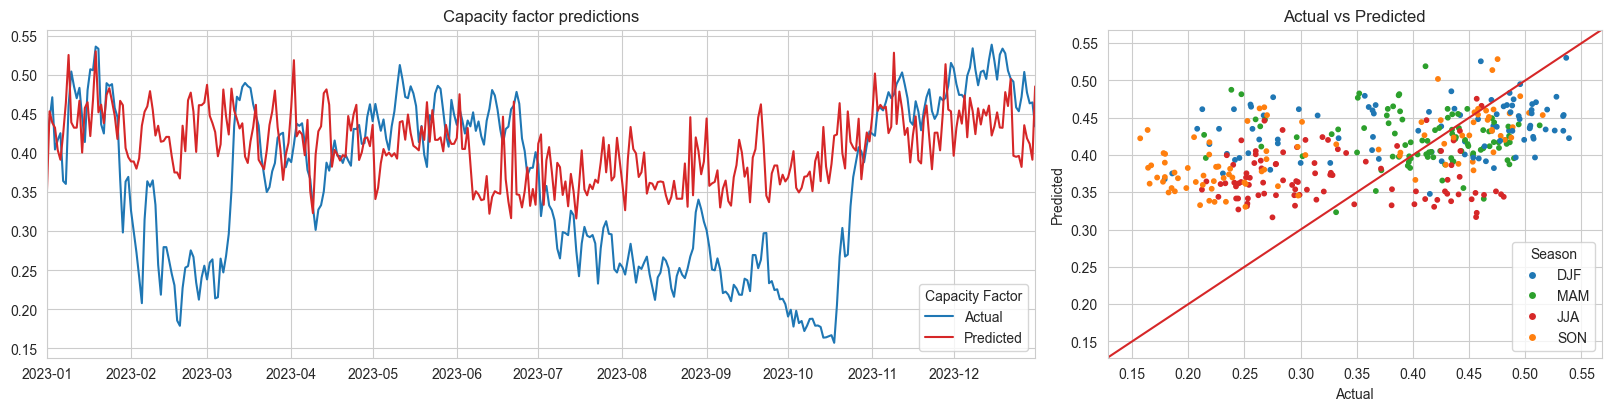

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train_pca, y_train)  # apprentissage supervisé

y_pred = gbr.predict(X_test_pca)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["GBRPCA"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Paramètres

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")

print()

display_result(y_test, y_pred)

# Test avec lag dans les  précipitations

R2: -0.355770
MSE: 0.014627



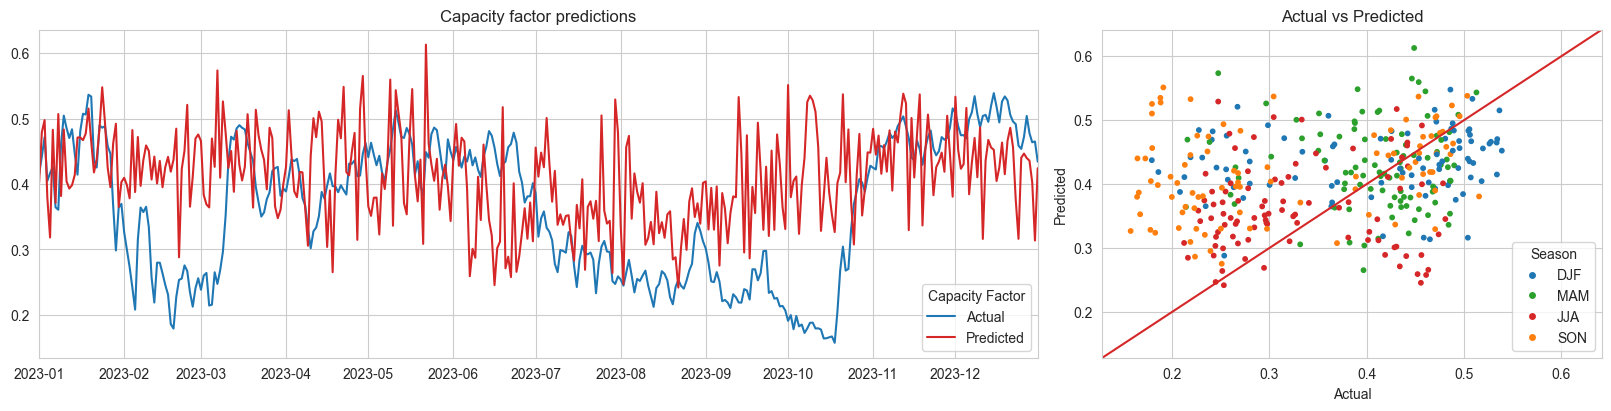

In [19]:
from sklearn.model_selection import GridSearchCV

params = {  }

reg = RandomForestRegressor(random_state=0)  # modèle d'arbre de décision
cv = GridSearchCV(reg, param_grid=params, n_jobs = 2)  # recherche par grille. CV pour cross validation.
cv.fit(X_train, y_train)  # apprentissage supervisé

y_pred = cv.predict(X_test)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["RFRCV"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

display_result(y_test, y_pred)

délai entre 1 et 30 jours

R2: -0.438988



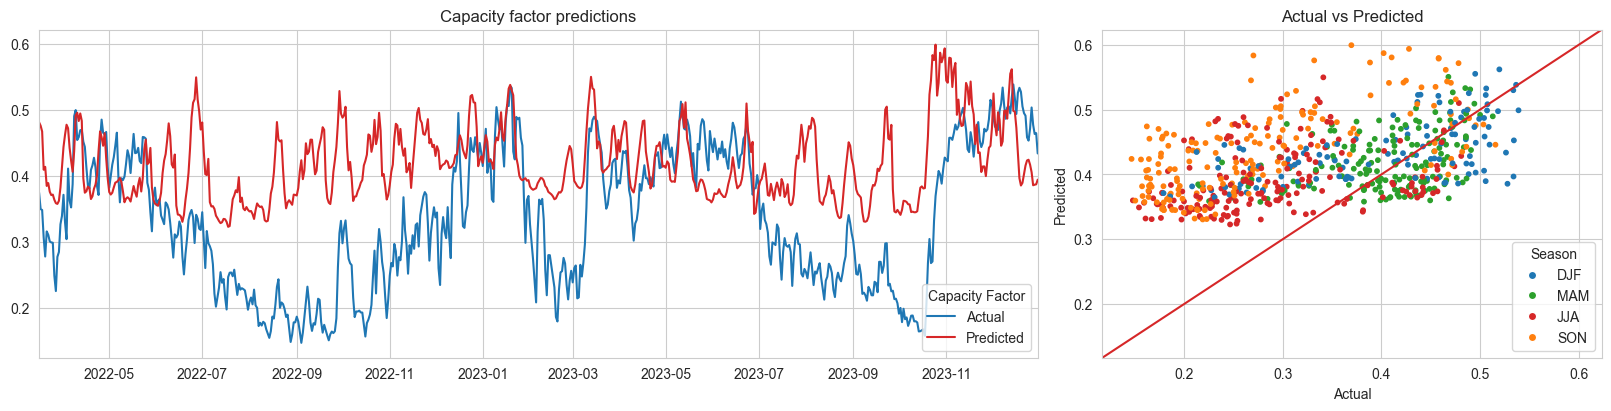

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

df = pd.DataFrame()  # renommé "df" pour être cohérent

df['y'] = data['CF']              # facteur de charge
df['TP'] = tpFR.mean(axis=1)  # précipitations moyennes
df['TA'] = taFR.mean(axis=1)  # température moyenne

# 2. Création des lags TP
for lag in range(1, 6):  # 1 à 5 jours
    df[f"TP_lag{lag}"] = df["TP"].shift(lag)

df = df.dropna()

# 3. Définir X et y
X = df[["TA", "TP", "TP_lag1", "TP_lag2", "TP_lag3", "TP_lag4", "TP_lag5"]]  # on entraine X sur les colonnes des 5 derniers jours 
y = df["y"]


# 4. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 5. Régression linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

results["LinReg"] = y_pred

# 6. Métriques et coefficients
r2 = r2_score(y_test, y_pred)


print(f"R2: {r2:.06f}")
print()

display_result(y_test, y_pred)

R2: -0.407150
MSE: 0.015264



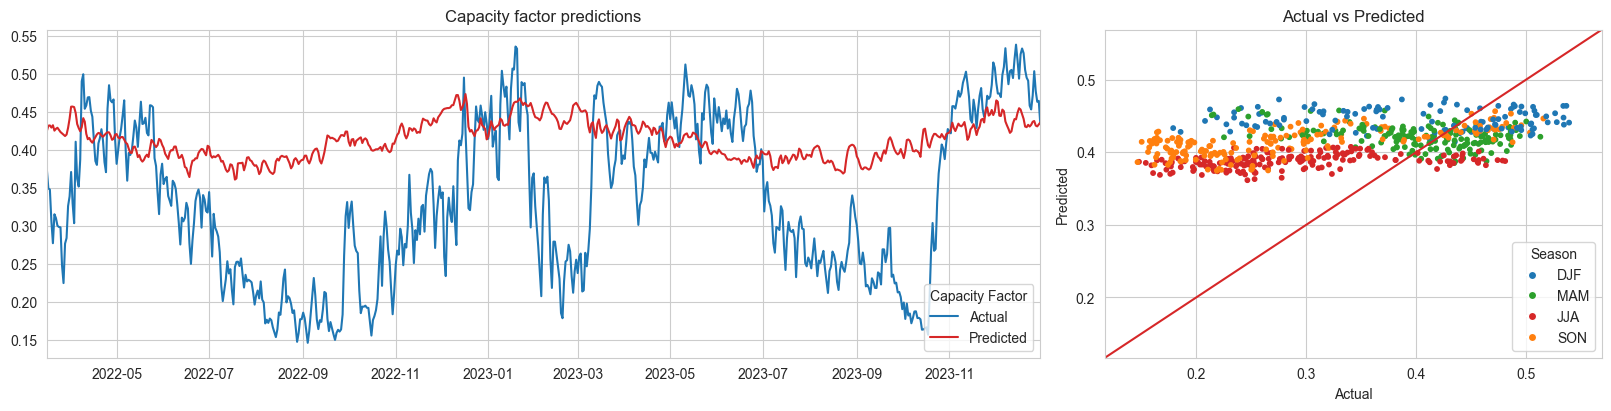

In [22]:
from sklearn.linear_model import Ridge
ridge = Ridge()  # modèle de régression linéaire avec pénalité L1
ridge.fit(X_train, y_train)  # apprentissage supervisé

y_pred = ridge.predict(X_test)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["Ridge"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)



print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")

print()

display_result(y_test, y_pred)

# Valeurs régionales et saisonnalité (ajout cos, sin)

Prédiction avec RF

R2: -0.110179
MSE: 0.011977



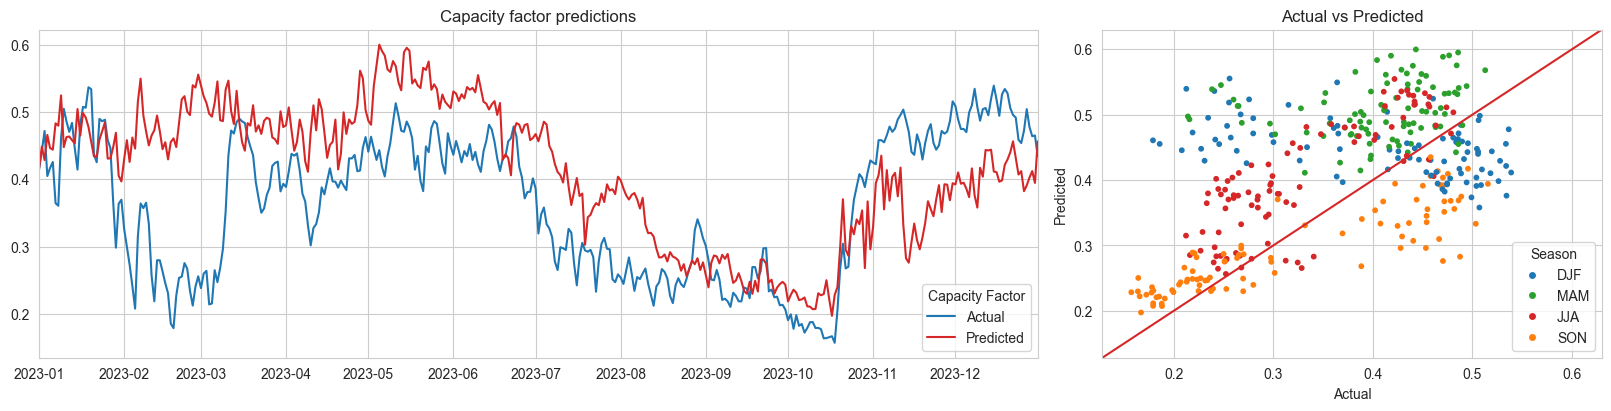

In [27]:
X_3 = pd.merge(ta_FR, tp_FR, left_index = True, right_index = True, suffixes = ("_TA", "_TP"))
X_3["cos"] = np.cos(data.index.dayofyear * 2 * np.pi/365)
X_3["sin"] = np.sin(data.index.dayofyear * 2 * np.pi/365)
y = data["CF"]

# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size=365, shuffle=False)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)  # apprentissage supervisé

y_pred = rf.predict(X_test)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results["RF_regions_seasons"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")

print()

display_result(y_test, y_pred)

# Prédiction en moyenne glissante sur les données

 Cération de nos nouvelles données

R2: 0.342020
MSE: 0.007099



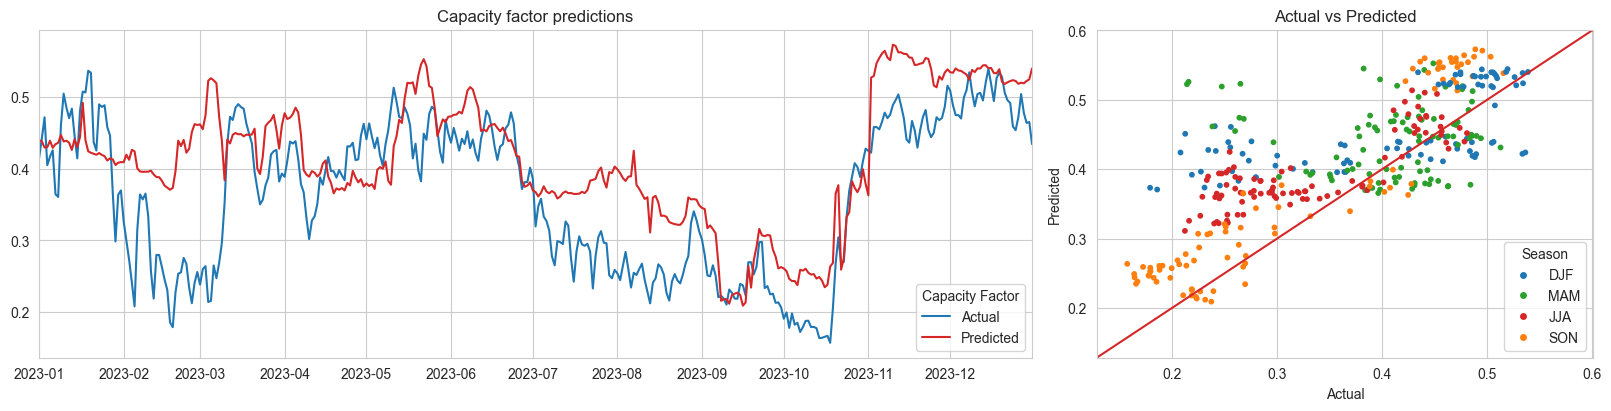

In [32]:
def crée_rolling(w1,w2):
    X = pd.merge(ta_FR.rolling(window=w1, min_periods=1).mean(), tp_FR.rolling(window=w2, min_periods=1).sum(), 
                 left_index = True, right_index = True, suffixes = ("_TA", "_TP"))
    # on fait une somme glissante pour la pluvio et une moyenne glissante pour les températures
    y = data["CF"]
    return X,y

X, y = crée_rolling(14,90)
# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

# Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std["cos"] = np.cos(X_train_std.index.dayofyear * 2 * np.pi/365)
X_train_std["sin"] = np.sin(X_train_std.index.dayofyear * 2 * np.pi/365)

results2 = {"Actual": y_test}

rf = RandomForestRegressor()
rf.fit(X_train, y_train)  # apprentissage supervisé

y_pred = rf.predict(X_test)  # prédiction
y_pred = pd.Series(y_pred, index=y_test.index)
results2["RF"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

display_result(y_test, y_pred)

Maintenant on cherche à déreminer les meilleures fenêtres pour chacunes des données, entre 1 et 90 jours.